# Full-Key Recovery

This notebook shows a **complete DL-SCA**: the full-key is recovered.

The following variables are fixed:
* ***Train Configuration***: D1-K5
* ***Attack Configuration***: D3-K0
* ***Target***: SBOX_OUT

In order to recover the full-key, **16 models are required**, one for each byte.\
Hyperparameter Tuning has been performed **separately for each model** (empirical results showed that it is not possible to recover a byte with a model that was not previously trained to detect it).

The 16 models have been trained with configuration D1-K5 and saved.\
The saved models are **loaded** and used to attack D3-K0.

In [1]:
# Basics
import numpy as np
import json
from tqdm import tqdm
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Custom
import sys
sys.path.insert(0, '../src/utils')
from data_loader import DataLoader, SplitDataLoader
import helpers
import constants
import results
sys.path.insert(0, '../src/modeling')
from network import Network

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [2]:
ATTACKED_CONFIG = 'D3-K0'
ATTACKED_KEY = np.array([int(kb, 16) for kb in constants.KEYS['K0']])

FULL_KEY_RECOVERY_FOLDER = f'{constants.RESULTS_PATH}/FullKeyRecovery'

SINGLE_RECOVERY_FILE = FULL_KEY_RECOVERY_FOLDER + '/single_key_recovery.npy'
N_TRACES_FILE = FULL_KEY_RECOVERY_FOLDER + '/n_traces.npy'
GES_FILE = FULL_KEY_RECOVERY_FOLDER + '/avg_ge_per_byte.npy'
GES_PLOT = FULL_KEY_RECOVERY_FOLDER + '/avg_ge_per_byte.png'
MODELS_FOLDER = FULL_KEY_RECOVERY_FOLDER + '/models'

In [3]:
def full_key_recovery(guessing_entropy=False):
    
    """
    Recovers the full attack key.
    
    Parameters:
        - guessing_entropy (bool, default: False):
            Whether or not computing the Guessing Entropy of the attack.
            If False, the result is the actual key.
            If True, the result is the Guessing Entropy for each byte.
            
    Returns:
        - ret_val (np.ndarray):
            Either the predicted key or the Guessing Entropy for each byte.
    """
    
    res = []
    
    for b in range(16):
        
        RES_ROOT = f'{constants.RESULTS_PATH}/DKTA/SBOX_OUT/byte{b}/1d'
        MODEL_FILE_NAME = f'model_b{b}.h5'
        MODEL_PATH = MODELS_FOLDER + f'/{MODEL_FILE_NAME}'
        
        model = load_model(MODEL_PATH)

        dl = DataLoader(
            [ATTACKED_CONFIG],
            n_tot_traces=5000,
            target='SBOX_OUT',
            byte_idx=b
        )
        x, y, pbs, tkb = dl.load()

        preds = model.predict(x)

        if guessing_entropy:
            ge = results.ge(
                preds=preds, 
                pltxt_bytes=pbs, 
                true_key_byte=tkb, 
                n_exp=100, 
                target='SBOX_OUT',
                n_traces=100
            )
            res.append(ge)
        else:
            predicted_key_bytes = results.retrieve_key_byte(
                preds=preds, 
                pltxt_bytes=pbs,  
                target='SBOX_OUT',
                n_traces=100
            ) 
            predicted_key_bytes = np.array(predicted_key_bytes)
            res.append(predicted_key_bytes)    
      
    res = np.array(res)
    
    ret_val = res if guessing_entropy else res.T # Transpose only the predicted keys: in the end each key will be seen "horizontally"
        
    return ret_val 

In [4]:
def plot_ges(ges, output_path, visualize_bytes=False):

    """
    Plots the provided GEs.
    
    Parameters:
        - ges (np.ndarray):
            Guessing Entropies to plot.
        - output_path (str):
            Absolute path to the PNG file containing the plot.
        - visualize_bytes (bool, default: False):
            Whether or not group the curves per row of bytes (4 groups, based on the resul of "byte_idx mod 4").
            "Rows" refers to the AES state, a 4x4 matrix.
            Each group has its own color in the plot.
    """
    
    # Set the color palette
    tot_colors = 4 if visualize_bytes else len(ges)
    cmap = plt.cm.jet # Google Turbo
    colors = cmap(range(0, cmap.N, int(cmap.N/tot_colors)))
    
    f, ax = plt.subplots(figsize=(15,8))
    
    for i, ge in enumerate(ges):
        
        ge = ge[:10]
        
        c_idx = i%4 if visualize_bytes else i
    
        ax.plot(ge, marker='o', color=colors[c_idx], label=f'Byte{i}')

        ax.set_title('GE All-Bytes')
        ax.set_xticks(range(len(ge)), labels=range(1, len(ge)+1)) 
        ax.set_xlabel('Number of traces')
        ax.set_ylabel('GE')
    
    plt.grid()
    plt.legend()
    
    f.savefig(
        output_path, 
        bbox_inches='tight', 
        dpi=600
    )
    
    plt.show()
    
    plt.close(f)

# Single Full-Key Recovery

In [5]:
predicted_keys = full_key_recovery()
np.save(SINGLE_RECOVERY_FILE, predicted_keys)

for i, key in enumerate(predicted_keys):
    if np.array_equal(key, ATTACKED_KEY):
        print(f'Correct key found in {i+1} traces:')
        print(f'Predicted key: {" ".join(helpers.int_to_hex(key)).upper()}')
        print(f'Correct key:   {" ".join(constants.KEYS["K0"]).upper()}')
        break

Correct key found in 9 traces:
Predicted key: 95 30 FC D9 D6 FD 1D 9B 62 03 28 01 B6 5C 1C 28
Correct key:   95 30 FC D9 D6 FD 1D 9B 62 03 28 01 B6 5C 1C 28


# Average Number of Traces for Full-Key Recovery

In [6]:
n_traces = []

for _ in tqdm(range(100), desc='Performing multiple Full-Key Recoveries: '):
    
    predicted_keys = full_key_recovery()

    for i, key in enumerate(predicted_keys):
        if np.array_equal(key, ATTACKED_KEY):
            n_traces.append(i+1)
            break
            
n_traces = np.array(n_traces)
np.save(N_TRACES_FILE, n_traces)

avg_n_traces = np.mean(n_traces)

print(f'Average Number of Traces for Full-Key Recovery: {avg_n_traces:.2f}')

Performing multiple Full-Key Recoveries: 100%|██████████| 100/100 [19:11<00:00, 11.51s/it]

Average Number of Traces for Full-Key Recovery: 8.99


On average (100 experiments), **it is possible to recover the correct full-key in less than 10 traces**.

# All-Bytes Guessing Entropy

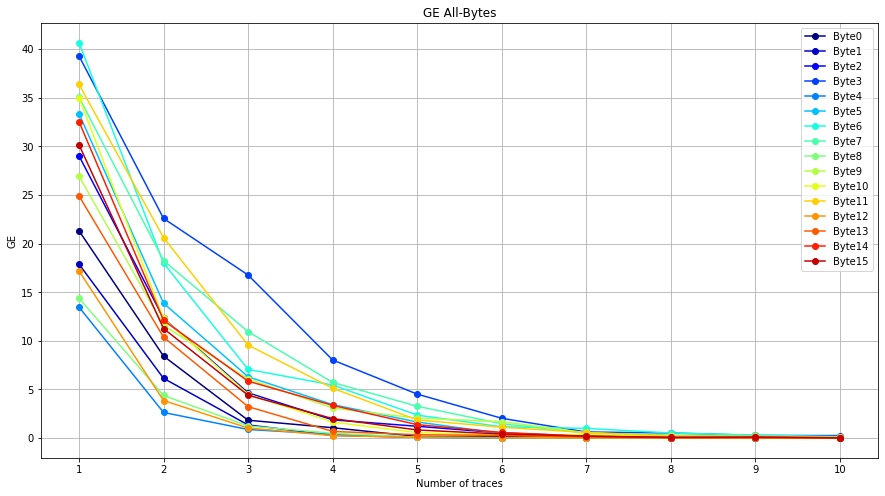

In [7]:
ges = full_key_recovery(guessing_entropy=True)
np.save(GES_FILE, ges)

plot_ges(ges, GES_PLOT)

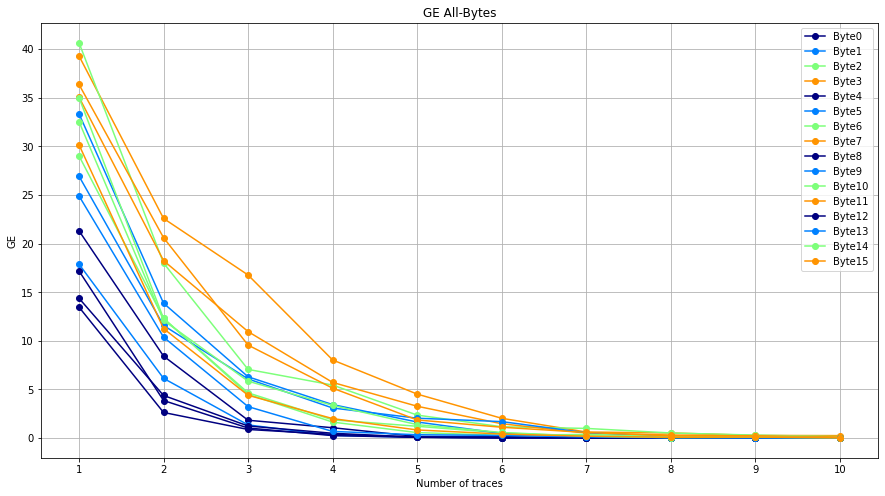

In [8]:
plot_ges(ges, GES_PLOT, visualize_bytes=True)

**All the Guessing Entropies converge to 0 in less than ... traces**.

It is clearly visible that:
* The **best Guessing Entropies** are the ones related to the bytes in the **first row** of the AES state (bytes 0, 4, 8, 12).
* The **worst Guessing Entropies** are the ones related to the bytes in the **last row** of the AES state (bytes 3, 7, 11, 15).